In [1]:
import numpy as np
import openpnm as op
import porespy as ps
import tifffile
import matplotlib.pyplot as plt

import numpy as np
import porespy as ps
import openpnm as op
import matplotlib.pyplot as plt
import math
import vtk
from vtk.util import numpy_support

D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\algorithms\_invasion_percolation.py:358: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _find_trapped_pores(inv_seq, indices, indptr, outlets):  # pragma: no cover
D:\Software\Anaconda\envs\puma_env\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


(150, 150, 150)


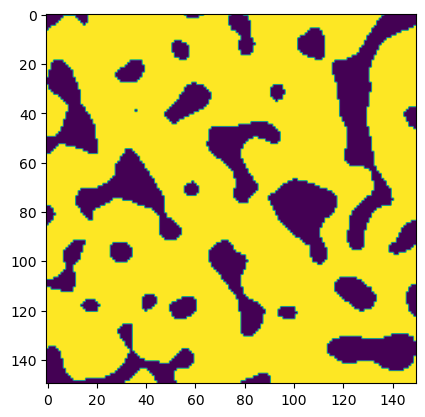

In [3]:
img = tifffile.imread('sample.tif') 
plt.imshow(img[10])
print (img.shape)

In [3]:
# Convert numpy array to VTK array
flat_volume = img.ravel(order='F')
vtk_data_array = numpy_support.numpy_to_vtk(num_array=flat_volume, deep=True, array_type=vtk.VTK_UNSIGNED_CHAR)

# Create vtkImageData
image_data = vtk.vtkImageData()
image_data.SetDimensions(img.shape[2], img.shape[1], img.shape[0])
image_data.GetPointData().SetScalars(vtk_data_array)

# Write to .vti
writer = vtk.vtkXMLImageDataWriter()
writer.SetFileName("output.vti")
writer.SetInputData(image_data)
writer.Write()

1

In [6]:
resolution= 1
img_bool = img > 0
img_inverted = ~img_bool
snow = ps.networks.snow2(img_inverted, voxel_size= resolution, r_max=4, sigma=0)
pn = op.io.network_from_porespy(snow.network)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/1151 [00:00<?, ?it/s]

In [9]:
import vtk
from vtk.util import numpy_support
import numpy as np
import openpnm as op

# Example: snow = ps.networks.snow2(img, voxel_size=resolution, r_max=4, sigma=0)
# pn = op.io.network_from_porespy(snow.network)

# Get coordinates and properties
pore_coords = pn['pore.coords']
pore_radii = pn['pore.inscribed_diameter'] / 2  # radius = diameter / 2
throat_conns = pn['throat.conns']
throat_diameters = pn['throat.inscribed_diameter']

# ---- VTK points for pores ----
points = vtk.vtkPoints()
for coord in pore_coords:
    points.InsertNextPoint(coord)

# ---- VTK lines for throats ----
lines = vtk.vtkCellArray()
for conns in throat_conns:
    line = vtk.vtkLine()
    line.GetPointIds().SetId(0, conns[0])
    line.GetPointIds().SetId(1, conns[1])
    lines.InsertNextCell(line)

# ---- Create VTK PolyData ----
poly_data = vtk.vtkPolyData()
poly_data.SetPoints(points)
poly_data.SetLines(lines)

# ---- Add pore radius as point data ----
radius_array = numpy_support.numpy_to_vtk(pore_radii.astype(np.float32), deep=True)
radius_array.SetName("pore_radius")
poly_data.GetPointData().AddArray(radius_array)

# ---- Add throat diameter as cell data ----
diam_array = numpy_support.numpy_to_vtk(throat_diameters.astype(np.float32), deep=True)
diam_array.SetName("throat_diameter")
poly_data.GetCellData().AddArray(diam_array)

# ---- Write to .vtp file ----
writer = vtk.vtkXMLPolyDataWriter()
writer.SetFileName("pore_network.vtp")
writer.SetInputData(poly_data)
writer.Write()


1

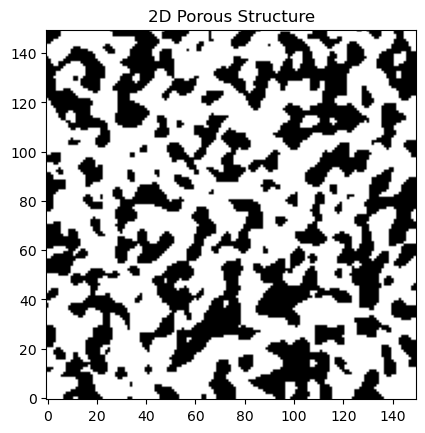

In [26]:
import porespy as ps
import matplotlib.pyplot as plt
import numpy as np

# Generate 2D porous image
img = ps.generators.blobs(shape=[150, 150], porosity=0.6, blobiness=2)

plt.imshow(img, origin='lower', cmap='gray')
plt.title("2D Porous Structure")
plt.show()


In [27]:
import openpnm as op

# Generate network using snow2
snow = ps.networks.snow2(img, voxel_size=1)


pn = op.io.network_from_porespy(snow.network)

h = op.utils.check_network_health(pn)
op.topotools.trim(network=pn, pores=h['disconnected_pores'])


def simple_diffusive_conductance(phase):
    ''' This function generates diffusivity values
        used for Ficks Simuation '''

    net = phase.network
    A = net['throat.cross_sectional_area']
    L = net['throat.total_length']
    conns = net['throat.conns']
    D = phase['pore.diffusivity'][conns].mean(axis=1)
    return D * A / L



# Define a phase and assign diffusive properties
air = op.phase.Air(network=pn)
air['pore.diffusivity'] = 1e-9  # [m²/s]

    # Add model to phase
air.add_model(
    propname='throat.diffusive_conductance',
    model=simple_diffusive_conductance)


# Create Fickian diffusion physics
phys = op.models.collections.physics.basic
air.add_model_collection(phys)
air.regenerate_models()


fd = op.algorithms.FickianDiffusion(network=pn, phase=air)
fd.set_value_BC(pores=pn.pores('xmin'), values=1.0)  # High concentration
fd.set_value_BC(pores=pn.pores('xmax'), values=0.0)  # Low concentration
fd.run()

# Get concentration results
concentration = fd['pore.concentration']


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/179 [00:00<?, ?it/s]

[07:41:16] WARNING  throat.entry_pressure was not run since the following property is missing:       ]8;id=134412;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=11410;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    'throat.surface_tension'                                                                       

           WARNING  throat.hydraulic_conductance was not run since the following property is         ]8;id=354004;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=157873;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.hydraulic_size_factors'                                                       

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=484126;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=713134;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.diffusive_size_factors'                                                       

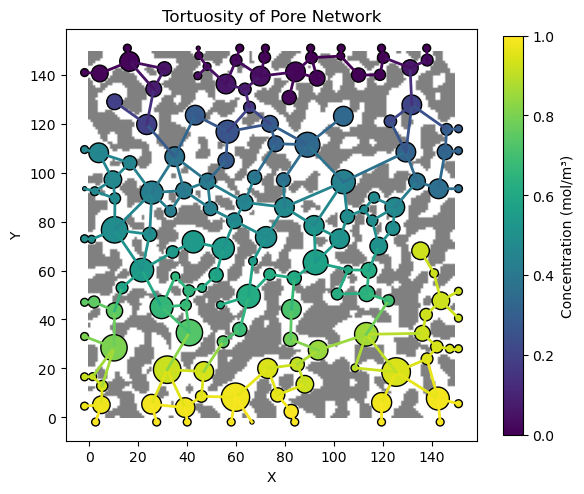

In [36]:
import matplotlib.pyplot as plt

# Image extent
shape = img.shape  # (rows, cols) = (Y, X)
#extent = [0, shape[1], 0, shape[0]]  # [x_min, x_max, y_min, y_max]

# Get concentrations and diameters
pc = fd['pore.concentration']
tc = fd.interpolate_data(propname='throat.concentration')
d = pn['pore.inscribed_diameter']

# Flip X and Y in pore and throat coordinates
coords = pn['pore.coords'][:, [1, 0]]# Swap X and Y
coords = coords - 3
conns = pn['throat.conns']

# Plot
fig, ax = plt.subplots(figsize=[6, 6])

# 1. Background image
ax.imshow(img, origin='lower', cmap='gray', alpha=0.5)

# 2. Plot throats
for i, (p1, p2) in enumerate(conns):
    x = [coords[p1, 0], coords[p2, 0]]
    y = [coords[p1, 1], coords[p2, 1]]
    ax.plot(x, y, color=plt.cm.viridis(tc[i]), linewidth=2)

# 3. Plot pores
sc = ax.scatter(coords[:, 0], coords[:, 1], c=pc, s=d**2 * 2, cmap='viridis', edgecolors='k')

# Colorbar
plt.colorbar(sc, ax=ax, label='Concentration (mol/m³)', shrink=0.7)

ax.set_title("Tortuosity of Pore Network")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.axis('on')
plt.tight_layout()
plt.savefig("Concentration_field.png", dpi=600, bbox_inches='tight')

plt.show()


In [30]:
import openpnm as op
import porespy as ps
import numpy as np
import matplotlib.pyplot as plt

# Generate network using snow2 (you already have this image)
snow = ps.networks.snow2(img, voxel_size=1)
pn = op.io.network_from_porespy(snow.network)

# Trim disconnected pores
h = op.utils.check_network_health(pn)
op.topotools.trim(network=pn, pores=h['disconnected_pores'])

# Define the fluid phase (Air, Water, etc.)
air = op.phase.Air(network=pn)
air['pore.viscosity'] = 1e-5  # Pa.s





def simple_hydraulic_conductance(phase):
    """
    Manually calculates hydraulic conductance for Stokes flow
    using the Hagen-Poiseuille equation approximation:
        g_h = (A^2) / (μ * L)
    where:
        A = throat cross-sectional area
        L = throat length
        μ = dynamic viscosity
    """
    net = phase.network
    A = net['throat.cross_sectional_area']
    L = net['throat.total_length']
    conns = net['throat.conns']
    
    # Mean viscosity of connected pores
    mu = phase['pore.viscosity'][conns].mean(axis=1)
    
    g_h = A**2 / (mu * L)
    return g_h

air.add_model(
    propname='throat.hydraulic_conductance',
    model=simple_hydraulic_conductance)


# Create Fickian diffusion physics
phys = op.models.collections.physics.basic
air.add_model_collection(phys)
air.regenerate_models()


# Set up and run Stokes Flow simulation
sf = op.algorithms.StokesFlow(network=pn, phase=air)
sf.set_value_BC(pores=pn.pores('xmin'), values=101325)  # High pressure
sf.set_value_BC(pores=pn.pores('xmax'), values=100000)  # Low pressure
sf.run()

# Manual calculation of throat velocities
G = air['throat.hydraulic_conductance']
P = sf['pore.pressure']
conns = pn['throat.conns']
dP = P[conns[:, 0]] - P[conns[:, 1]]  # Pressure drop across each throat
flow = G * dP  # Volumetric flow per throat [m³/s]

# Calculate throat velocity: v = Q / A
A = pn['throat.cross_sectional_area']
velocity = flow / A  # [m/s]

# Store it for plotting
pn['throat.velocity_magnitude'] = np.abs(velocity)


# Get pressure and velocity
pressure = sf['pore.pressure']
velocity = pn['throat.velocity_magnitude']

# Calculate permeability using Darcy's law:
flow_rate = sf.rate(pores=pn.pores('xmax'))  # [m³/s]
L = pn['pore.coords'][:, 0].ptp()  # Length in flow direction [m]
A = img.shape[1] * 1**2  # Cross-sectional area [m²], assuming voxel_size = 1 µm = 1e-6 m
mu = air['pore.viscosity'].mean()
delta_P = 101325 - 100000  # Pa

k = flow_rate * mu * L / (A * delta_P)  # [m²]
#print(f"Estimated Permeability: {k:.3e} m²")




0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/179 [00:00<?, ?it/s]

[07:42:31] WARNING  throat.entry_pressure was not run since the following property is missing:       ]8;id=898861;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=22332;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    'throat.surface_tension'                                                                       

           WARNING  throat.hydraulic_conductance was not run since the following property is         ]8;id=409692;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=550603;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.hydraulic_size_factors'                                                       

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=202420;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=177816;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.diffusive_size_factors'                                                       

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=393815;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=102132;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.diffusive_size_factors'                                                       

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=120285;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=813672;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.diffusive_size_factors'                                                       

In [31]:
# Compute pore velocity as the average of connected throat velocities
import scipy.sparse

throat_vel = pn['throat.velocity_magnitude']
conns = pn['throat.conns']
Np = pn.Np
Nt = pn.Nt

# Build incidence matrix
row = np.hstack([conns[:, 0], conns[:, 1]])
col = np.hstack([np.arange(Nt), np.arange(Nt)])
data = np.ones(len(row))
incidence = scipy.sparse.coo_matrix((data, (row, col)), shape=(Np, Nt))

# Average velocity at each pore
numerator = incidence @ throat_vel
denominator = np.array(incidence.sum(axis=1)).flatten()
pore_vel = numerator / denominator
pore_vel[np.isnan(pore_vel)] = 0  # Replace NaNs with 0
pn['pore.velocity_magnitude'] = pore_vel


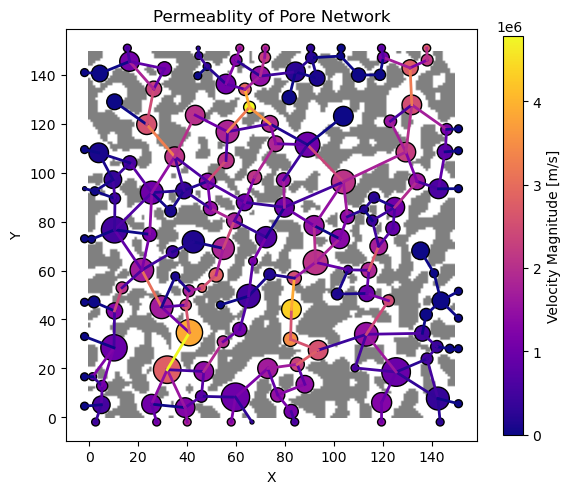

In [35]:
# ---------- Visualization (Velocity Only) ----------

coords = pn['pore.coords'][:, [1, 0]] - 3
conns = pn['throat.conns']
tc = pn['throat.velocity_magnitude']
pc = pn['pore.velocity_magnitude']
d = pn['pore.inscribed_diameter']

fig, ax = plt.subplots(figsize=[6, 6])
ax.imshow(img, origin='lower', cmap='gray', alpha=0.5)

# Plot throats colored by velocity
for i, (p1, p2) in enumerate(conns):
    x = [coords[p1, 0], coords[p2, 0]]
    y = [coords[p1, 1], coords[p2, 1]]
    ax.plot(x, y, color=plt.cm.plasma(tc[i] / tc.max()), linewidth=2)

# Plot pores colored by velocity
sc = ax.scatter(coords[:, 0], coords[:, 1], c=pc, s=d**2 * 2, cmap='plasma', edgecolors='k')

plt.colorbar(sc, ax=ax, label='Velocity Magnitude [m/s]', shrink=0.7)
ax.set_title("Permeablity of Pore Network")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.axis('on')
plt.tight_layout()
plt.savefig("velocity_field.png", dpi=600, bbox_inches='tight')
plt.show()
